##### Model Training

In [21]:
# For data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample

import xgboost as xgb
import lightgbm as lgb
import catboost 
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import make_pipeline 
from sklearn.model_selection import StratifiedKFold


# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

#For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
df0 = pd.read_csv(r"D:\Documents\GitHub\credit_line_eligibility\data\cleaned_data.csv")
df0.head()

,loan_amnt,term,int_rate,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc
0,10000.0,36,11.44,141326,1.202703,117413,1,45389,1.089146,16.0,1.434536,41.8,25.0
1,8000.0,36,11.99,173740,0.060161,117413,1,207128,0.623256,17.0,0.681703,53.3,27.0
2,15600.0,36,10.49,141326,-0.796125,117893,1,73637,-0.513208,13.0,0.079328,92.2,26.0
3,7200.0,36,6.49,141326,-0.319423,117413,1,73637,-2.120210,6.0,-0.739714,21.5,13.0
4,24375.0,60,17.27,173740,-0.281432,111005,0,73637,1.893119,13.0,0.927930,69.8,43.0


In [3]:
df0.shape

(346311, 13)

In [4]:
# Drop the target column to define X dataset
X = df0.drop(columns=['loan_status'])
X.reset_index(inplace=True, drop=True)
# Define the target variable in y dataset
y = df0['loan_status']
y.reset_index(drop=True, inplace=True)

# Split data before standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42, stratify=y_train)



### Training the classifier models on non-SMOTE data

##### XGBClassifier

In [ ]:
from optuna_integration.xgboost import XGBoostPruningCallback
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

# Create samples of 70K for training and 50K for validation datasets for optuna to study
xgb_X_train, xgb_y_train = resample(X_train, y_train, n_samples=70000, random_state=42, stratify=y_train)
xgb_X_val, xgb_y_val = resample(X_val, y_val, n_samples=50000, random_state=42, stratify=y_val)

# Create a function to optimize hyperparameters using Optuna
def objective(trial):

    # Define hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "gpu_hist",  
        "verbosity":0,
        "verbose":-1,
        "scale_pos_weight": 0.2334,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
        "early_stopping_rounds":20,
        "callbacks":[XGBoostPruningCallback(trial, "validation_0-logloss")],
    }

    model = xgb.XGBClassifier(**params)
    model.fit(xgb_X_train, xgb_y_train, eval_set=[(X_val, y_val)], verbose=False )

    # Predict on validation set
    preds = model.predict(xgb_X_val)
    roc_auc = roc_auc_score(xgb_y_val, preds)
    return roc_auc

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# # Best parameters
print("Best ROC-AUC score:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-04-15 23:05:51,327] A new study created in memory with name: no-name-70054441-0cef-4deb-bfb9-0a5574212e9b
[I 2025-04-15 23:06:07,191] Trial 0 finished with value: 0.6177061079805471 and parameters: {'n_estimators': 450, 'learning_rate': 0.1422138991813404, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 0.006470921893129444, 'subsample': 0.9814981874686797, 'colsample_bytree': 0.5542806676028722, 'lambda': 0.005751942503162312, 'alpha': 0.3485225997876736}. Best is trial 0 with value: 0.6177061079805471.
[I 2025-04-15 23:06:10,457] Trial 1 finished with value: 0.6524146621785348 and parameters: {'n_estimators': 200, 'learning_rate': 0.10542253168791701, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 0.001292541355319069, 'subsample': 0.6812601282997186, 'colsample_bytree': 0.6406073632487512, 'lambda': 2.661358505894813, 'alpha': 0.04561421341433407}. Best is trial 1 with value: 0.6524146621785348.
[I 2025-04-15 23:06:17,303] Trial 2 finished with value: 0.6493367790190653 and

Best ROC-AUC score: 0.6524146621785348
Best Parameters: {'n_estimators': 200, 'learning_rate': 0.10542253168791701, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 0.001292541355319069, 'subsample': 0.6812601282997186, 'colsample_bytree': 0.6406073632487512, 'lambda': 2.661358505894813, 'alpha': 0.04561421341433407}


In [6]:
#----------------------------------------------------------
# Train final model using best params on full training data
#----------------------------------------------------------

xgb_best_params = study.best_params
xgb_best = xgb.XGBClassifier(**xgb_best_params, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=0.2334, objective="binary:logistic", random_state=42)
xgb=xgb_best.fit(X_train, y_train)


#---------------------------------------------------------
# Evaluate the model on the validation set
#---------------------------------------------------------

y_pred_val = xgb_best.predict(xgb_X_val)
xgb_preds_val = xgb_best.predict_proba(xgb_X_val)[:, 1]    #tbr

f1 = f1_score(xgb_y_val, y_pred_val)
roc_auc = roc_auc_score(xgb_y_val, y_pred_val)
print("Metrics for Validation data:/n")
print(f"ROC-AUC:{roc_auc:.4f}") 
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(xgb_y_val, y_pred_val))

#---------------------------------------------------------
# Evaluate the model on the test set
#---------------------------------------------------------

y_pred = xgb_best.predict(X_test)
xgb_preds = xgb_best.predict_proba(X_val)[:, 1]   #tbr

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("Metrics for Test data:/n")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Metrics for Validation data:/n
ROC-AUC:0.6568
F1-score: 0.7544

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.66      0.42      9463
           1       0.89      0.65      0.75     40537

    accuracy                           0.65     50000
   macro avg       0.60      0.66      0.59     50000
weighted avg       0.78      0.65      0.69     50000

Metrics for Test data:/n
ROC-AUC: 0.6571
F1-score: 0.7553

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.66      0.42     19662
           1       0.89      0.66      0.76     84232

    accuracy                           0.66    103894
   macro avg       0.60      0.66      0.59    103894
weighted avg       0.78      0.66      0.69    103894



##### LGBM Classifier

In [9]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from optuna.pruners import HyperbandPruner
import lightgbm as lgb

# Create samples of 70K for training and 50K for validation datasets for optuna to study
lgb_X_train, lgb_y_train = resample(X_train, y_train, n_samples=70000, random_state=42, stratify=y_train)
lgb_X_val, lgb_y_val = resample(X_val, y_val, n_samples=50000, random_state=42, stratify=y_val)

# Create a function to optimize hyperparameters using Optuna
def objective(trial):
    # Define hyperparameter search space
    param_grid = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "verbose":-1,
        "boosting_type": 'gbdt', 
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 400, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    }
    
    train_data = lgb.Dataset(lgb_X_train, label=lgb_y_train)
    val_data = lgb.Dataset(lgb_X_val, label=lgb_y_val)
    
    model = lgb.train(
        param_grid,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "valid_0"],
        callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(0)],
    )
    
    preds = model.predict(lgb_X_val)
    return roc_auc_score(lgb_y_val, preds)
    

# Run Optuna optimization
study = optuna.create_study(direction="maximize", pruner=HyperbandPruner)
study.optimize(objective, n_trials=30)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Best parameters
print("Best ROC-AUC Score:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-04-15 23:11:43,701] A new study created in memory with name: no-name-ed463541-63a0-4a61-996f-e84776c08c29
[I 2025-04-15 23:11:48,711] Trial 0 finished with value: 0.7087712030609172 and parameters: {'learning_rate': 0.09161239330776785, 'num_leaves': 180, 'max_depth': 4, 'min_data_in_leaf': 83, 'lambda_l1': 3.5713889149908544, 'lambda_l2': 0.017286686095465627, 'feature_fraction': 0.9798114349252715, 'bagging_fraction': 0.5585526423094116, 'bagging_freq': 5}. Best is trial 0 with value: 0.7087712030609172.
[I 2025-04-15 23:11:53,607] Trial 1 finished with value: 0.706001453367126 and parameters: {'learning_rate': 0.0752617962345343, 'num_leaves': 120, 'max_depth': 9, 'min_data_in_leaf': 39, 'lambda_l1': 0.05975431937640061, 'lambda_l2': 0.17537945985382214, 'feature_fraction': 0.7498912746128923, 'bagging_fraction': 0.5012383656166256, 'bagging_freq': 2}. Best is trial 0 with value: 0.7087712030609172.
[I 2025-04-15 23:11:58,161] Trial 2 finished with value: 0.6977909147628207 

Best ROC-AUC Score: 0.7099323203868233
Best Parameters: {'learning_rate': 0.07566756551348645, 'num_leaves': 280, 'max_depth': 5, 'min_data_in_leaf': 59, 'lambda_l1': 0.005795512255160428, 'lambda_l2': 2.536670462412046, 'feature_fraction': 0.734197789210133, 'bagging_fraction': 0.778175164439795, 'bagging_freq': 1}


In [11]:
from lightgbm import LGBMClassifier

#-----------------------------------------------------------
# Train final LightGBM model with best parameters
#-----------------------------------------------------------
lgb_best_params = study.best_params
lgb_best = LGBMClassifier(**lgb_best_params, class_weight='balanced')
lgb_best.fit(X_train, y_train, eval_set=[(X_val, y_val)])

#-----------------------------------------------------------
# Predictions on validation set
#-----------------------------------------------------------

y_pred_val = lgb_best.predict(X_val)

f1 = f1_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_pred_val)
print("Metrics for Validation data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))

#-------------------------------------------------------------
# Predictions on test set
#-------------------------------------------------------------

y_pred = lgb_best.predict(X_test)

# Evaluate results
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Metrics for Test data:")

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Metrics for Validation data:
ROC-AUC: 0.6527
F1-score: 0.7505

Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.66      0.42     13764
           1       0.89      0.65      0.75     58962

    accuracy                           0.65     72726
   macro avg       0.60      0.65      0.58     72726
weighted avg       0.78      0.65      0.69     72726

Confusion Matrix:
 [[ 9038  4726]
 [20711 38251]]
Metrics for Test data:
ROC-AUC: 0.6571
F1-score: 0.7519

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.66      0.42     19662
           1       0.89      0.65      0.75     84232

    accuracy                           0.65    103894
   macro avg       0.60      0.66      0.59    103894
weighted avg       0.78      0.65      0.69    103894

Confusion Matrix:
 [[13066  6596]
 [29517 54715]]


##### CatBoost Classifier

In [7]:
import optuna
from catboost import CatBoostClassifier
from sklearn.utils import resample

# Create samples of 70K for training and 50K for validation datasets for optuna to study
cat_X_train, cat_y_train = resample(X_train, y_train, n_samples=70000, random_state=42, stratify=y_train)
cat_X_val, cat_y_val = resample(X_val, y_val, n_samples=50000, random_state=42, stratify=y_val)

# Define the objective function for Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_seed": 42,
        "scale_pos_weight": 0.2334,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "verbose": 0
        # "allow_writing_files": False
    }

    model = CatBoostClassifier(**params)

    model.fit(
        cat_X_train, cat_y_train,
        eval_set=(cat_X_val, cat_y_val),
        early_stopping_rounds=50
    )

    preds = model.predict_proba(cat_X_val)[:, 1]
    auc = roc_auc_score(cat_y_val, preds)
    return auc

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best parameters
print("Best AUC score:", study.best_value)
print("Best params:", study.best_params)

[I 2025-04-16 00:13:40,331] A new study created in memory with name: no-name-6db78650-db3f-4cb6-9aa9-1e828dcdb60f
[I 2025-04-16 00:13:54,133] Trial 0 finished with value: 0.7086561709639865 and parameters: {'iterations': 456, 'learning_rate': 0.1833460002308931, 'depth': 5, 'l2_leaf_reg': 1.073306060434001}. Best is trial 0 with value: 0.7086561709639865.
[I 2025-04-16 00:14:08,614] Trial 1 finished with value: 0.7098555741020819 and parameters: {'iterations': 475, 'learning_rate': 0.1956486528077542, 'depth': 4, 'l2_leaf_reg': 7.030127163848583}. Best is trial 1 with value: 0.7098555741020819.
[I 2025-04-16 00:14:26,147] Trial 2 finished with value: 0.7059500015525221 and parameters: {'iterations': 996, 'learning_rate': 0.06412944571616218, 'depth': 9, 'l2_leaf_reg': 3.5637773886623187}. Best is trial 1 with value: 0.7098555741020819.
[I 2025-04-16 00:14:39,810] Trial 3 finished with value: 0.7047656478811999 and parameters: {'iterations': 905, 'learning_rate': 0.03268676781523431, 'd

Best AUC score: 0.7113822177674735
Best params: {'iterations': 868, 'learning_rate': 0.10671349736882857, 'depth': 4, 'l2_leaf_reg': 0.24004502741570286}


In [9]:
from catboost import CatBoostClassifier

#-----------------------------------------------------------
# Train final model with best params
#------------------------------------------------------------
best_params = study.best_params
catboost_best = CatBoostClassifier(**best_params, scale_pos_weight=0.2334, eval_metric="AUC",loss_function="Logloss", random_seed=42, verbose=0)
catboost_best.fit(X_train, y_train)

#------------------------------------------------------------
# Predictions on validation set
#------------------------------------------------------------

y_pred_val = catboost_best.predict(X_val)

roc_auc = roc_auc_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)

print("Metrics for Validation data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))
print("Confusion Matrix:", confusion_matrix(y_val, y_pred_val))

#--------------------------------------------------------------
# Predictions on test set
#--------------------------------------------------------------

y_pred = catboost_best.predict(X_test)

# Evaluate results
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Metrics for Test data:")

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))


Metrics for Validation data:
ROC-AUC: 0.6539
F1-score: 0.7543

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.65      0.42     13764
           1       0.89      0.65      0.75     58962

    accuracy                           0.65     72726
   macro avg       0.60      0.65      0.59     72726
weighted avg       0.78      0.65      0.69     72726

Confusion Matrix: [[ 8992  4772]
 [20368 38594]]
Metrics for Test data:
ROC-AUC: 0.6591
F1-score: 0.7566

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.66      0.42     19662
           1       0.89      0.66      0.76     84232

    accuracy                           0.66    103894
   macro avg       0.60      0.66      0.59    103894
weighted avg       0.78      0.66      0.69    103894

Confusion Matrix: [[13008  6654]
 [28926 55306]]


##### Logistic Regression

In [13]:
#-------------------------------------------------------------
# Train the Logistic Regression model
#-------------------------------------------------------------
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)

#-------------------------------------------------------------
# Evaluate the model on the validation set
#-------------------------------------------------------------

y_pred = lr_model.predict(X_val)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)
print("Metrics for Validation data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

#-------------------------------------------------------------
# Evaluate the model on the test set
#-------------------------------------------------------------

y_pred = lr_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("\nMetrics for Test data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Metrics for Validation data:
ROC-AUC: 0.6456
F1-score: 0.7561
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.63      0.41     13764
           1       0.88      0.66      0.76     58962

    accuracy                           0.65     72726
   macro avg       0.59      0.65      0.58     72726
weighted avg       0.77      0.65      0.69     72726

Confusion Matrix:
[[ 8686  5078]
 [20037 38925]]

Metrics for Test data:
ROC-AUC: 0.6509
F1-score: 0.7571
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.64      0.41     19662
           1       0.89      0.66      0.76     84232

    accuracy                           0.66    103894
   macro avg       0.60      0.65      0.59    103894
weighted avg       0.78      0.66      0.69    103894

Confusion Matrix:
[[12615  7047]
 [28629 55603]]


### Training Classifier models on SMOTE data

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')

# Resample the training data using SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

##### XGBoost Classifier

In [15]:
from optuna_integration.xgboost import XGBoostPruningCallback
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

# Create samples of 70K for training and 50K for validation datasets for optuna to study
xgb_X_train, xgb_y_train = resample(X_train_smote, y_train_smote, n_samples=70000, random_state=42, stratify=y_train_smote)
xgb_X_val, xgb_y_val = resample(X_val, y_val, n_samples=50000, random_state=42, stratify=y_val)

# Create a function to optimize hyperparameters using Optuna
def objective(trial):

    # Define hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "gpu_hist",  
        "verbosity":0,
        "verbose":-1,
        "scale_pos_weight": 0.2334,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
        "eval_metric": "logloss",
        "early_stopping_rounds":20,
        "callbacks":[XGBoostPruningCallback(trial, "validation_0-logloss")],
    }

    model = xgb.XGBClassifier(**params)
    model.fit(xgb_X_train, xgb_y_train, eval_set=[(X_val, y_val)], verbose=False )

    # Predict on validation set
    preds = model.predict(xgb_X_val)
    roc_auc = roc_auc_score(xgb_y_val, preds)
    return roc_auc

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# # Best parameters
print("Best ROC-AUC score:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-04-16 00:35:04,817] A new study created in memory with name: no-name-bec9c97f-288c-4e5f-aef3-4afd24bc76df
[I 2025-04-16 00:35:15,685] Trial 0 finished with value: 0.6373881867045554 and parameters: {'n_estimators': 300, 'learning_rate': 0.04800254210374117, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.4869414142258927, 'subsample': 0.6377417959738878, 'colsample_bytree': 0.5579063687531418, 'lambda': 2.5251309042464367, 'alpha': 1.5180775791143115}. Best is trial 0 with value: 0.6373881867045554.
[I 2025-04-16 00:35:20,518] Trial 1 finished with value: 0.6301763951571936 and parameters: {'n_estimators': 150, 'learning_rate': 0.09075906796936843, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.0025022986400550814, 'subsample': 0.7643557758725538, 'colsample_bytree': 0.6584137436225257, 'lambda': 1.6338175941144089, 'alpha': 0.01183648878146185}. Best is trial 0 with value: 0.6373881867045554.
[I 2025-04-16 00:35:24,669] Trial 2 finished with value: 0.5951604504517864 and

Best ROC-AUC score: 0.6373881867045554
Best Parameters: {'n_estimators': 300, 'learning_rate': 0.04800254210374117, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.4869414142258927, 'subsample': 0.6377417959738878, 'colsample_bytree': 0.5579063687531418, 'lambda': 2.5251309042464367, 'alpha': 1.5180775791143115}


In [17]:
#----------------------------------------------------------
# Train final model using best params on full training data
#----------------------------------------------------------

xgb_best_params = study.best_params
xgb_best = xgb.XGBClassifier(**xgb_best_params, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=0.2334, objective="binary:logistic", random_state=42)
xgb=xgb_best.fit(X_train_smote, y_train_smote)


#---------------------------------------------------------
# Evaluate the model on the validation set
#---------------------------------------------------------

y_pred_val = xgb_best.predict(X_val)
xgb_preds_val = xgb_best.predict_proba(X_val)[:, 1]    #tbr

f1 = f1_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_pred_val)
print("Metrics for Validation data:/n")
print(f"ROC-AUC:{roc_auc:.4f}") 
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

#---------------------------------------------------------
# Evaluate the model on the test set
#---------------------------------------------------------

y_pred = xgb_best.predict(X_test)

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("Metrics for Test data:/n")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Metrics for Validation data:/n
ROC-AUC:0.6399
F1-score: 0.6741

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.74      0.40     13764
           1       0.90      0.54      0.67     58962

    accuracy                           0.58     72726
   macro avg       0.59      0.64      0.54     72726
weighted avg       0.78      0.58      0.62     72726

Metrics for Test data:/n
ROC-AUC: 0.6396
F1-score: 0.6739

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.74      0.40     19662
           1       0.90      0.54      0.67     84232

    accuracy                           0.58    103894
   macro avg       0.59      0.64      0.54    103894
weighted avg       0.78      0.58      0.62    103894



In [34]:
from xgboost import XGBClassifier

#-
# Define the pipeline to apply SMOTE on the training data in CV folds and then train the XGB Classifier model
#-
smote_pipeline = make_pipeline(SMOTE(sampling_strategy='auto', random_state=42), XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=0.24))
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(smote_pipeline, X_train, y_train, scoring='roc_auc', cv=kf)

smote_pipeline.fit(X_train, y_train)
y_pred = smote_pipeline.predict(X_val)

print("Cross Validation AUC Scores on every fold: {}".format(score))

print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print("Average Cross Validation AUC score: {}".format(score.mean()))
print("Classificatoin Report\n", classification_report(y_val, y_pred))

Cross Validation AUC Scores on every fold: [0.68600243 0.68735273 0.69548355 0.69424062 0.69083589]
ROC AUC Score: 0.6371816891685621
Average Cross Validation AUC score: 0.6907830452210236
Classificatoin Report
               precision    recall  f1-score   support

           0       0.27      0.71      0.40     13764
           1       0.89      0.56      0.69     58962

    accuracy                           0.59     72726
   macro avg       0.58      0.64      0.54     72726
weighted avg       0.78      0.59      0.63     72726



##### LGBM Classifier

In [18]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from optuna.pruners import HyperbandPruner
import lightgbm as lgb

# Create samples of 70K for training and 50K for validation datasets for optuna to study
lgb_X_train, lgb_y_train = resample(X_train_smote, y_train_smote, n_samples=70000, random_state=42, stratify=y_train)
lgb_X_val, lgb_y_val = resample(X_val, y_val, n_samples=50000, random_state=42, stratify=y_val)

# Create a function to optimize hyperparameters using Optuna
def objective(trial):
    # Define hyperparameter search space
    param_grid = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "verbose":-1,
        "boosting_type": 'gbdt', 
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 400, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    }
    
    train_data = lgb.Dataset(lgb_X_train, label=lgb_y_train)
    val_data = lgb.Dataset(lgb_X_val, label=lgb_y_val)
    
    model = lgb.train(
        param_grid,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=["train", "valid_0"],
        callbacks=[lgb.early_stopping(50, verbose=False), lgb.log_evaluation(0)],
    )
    
    preds = model.predict(lgb_X_val)
    return roc_auc_score(lgb_y_val, preds)
    

# Run Optuna optimization
study = optuna.create_study(direction="maximize", pruner=HyperbandPruner)
study.optimize(objective, n_trials=30)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Best parameters
print("Best ROC-AUC Score:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-04-16 00:39:55,522] A new study created in memory with name: no-name-a6677930-e02e-4c22-a17a-c470aded2656
[I 2025-04-16 00:40:01,138] Trial 0 finished with value: 0.7091092777444421 and parameters: {'learning_rate': 0.05185040015658235, 'num_leaves': 340, 'max_depth': 6, 'min_data_in_leaf': 65, 'lambda_l1': 5.067034689563009, 'lambda_l2': 0.0014985404224404817, 'feature_fraction': 0.8399027556423473, 'bagging_fraction': 0.8761807042880696, 'bagging_freq': 7}. Best is trial 0 with value: 0.7091092777444421.
[I 2025-04-16 00:40:06,751] Trial 1 finished with value: 0.7001334282648033 and parameters: {'learning_rate': 0.1270534009865282, 'num_leaves': 240, 'max_depth': 12, 'min_data_in_leaf': 59, 'lambda_l1': 0.1561335488734587, 'lambda_l2': 0.05910901434642774, 'feature_fraction': 0.9774741429000645, 'bagging_fraction': 0.9193152741456513, 'bagging_freq': 5}. Best is trial 0 with value: 0.7091092777444421.
[I 2025-04-16 00:40:11,063] Trial 2 finished with value: 0.7042835553011504

Best ROC-AUC Score: 0.7098972866463125
Best Parameters: {'learning_rate': 0.05490623103643512, 'num_leaves': 300, 'max_depth': 7, 'min_data_in_leaf': 150, 'lambda_l1': 0.0259739811707907, 'lambda_l2': 0.3939823118664653, 'feature_fraction': 0.9238903434419878, 'bagging_fraction': 0.7705948330993367, 'bagging_freq': 3}


In [19]:
from lightgbm import LGBMClassifier

#-----------------------------------------------------------
# Train final LightGBM model with best parameters
#-----------------------------------------------------------
lgb_best_params = study.best_params
lgb_best = LGBMClassifier(**lgb_best_params, class_weight='balanced')
lgb_best.fit(X_train_smote, y_train_smote, eval_set=[(X_val, y_val)])

#-----------------------------------------------------------
# Predictions on validation set
#-----------------------------------------------------------

y_pred_val = lgb_best.predict(X_val)

f1 = f1_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_pred_val)
print("Metrics for Validation data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))

#-------------------------------------------------------------
# Predictions on test set
#-------------------------------------------------------------

y_pred = lgb_best.predict(X_test)

# Evaluate results
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Metrics for Test data:")

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Metrics for Validation data:
ROC-AUC: 0.5995
F1-score: 0.8620

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.32      0.35     13764
           1       0.85      0.88      0.86     58962

    accuracy                           0.77     72726
   macro avg       0.61      0.60      0.61     72726
weighted avg       0.76      0.77      0.76     72726

Confusion Matrix:
 [[ 4425  9339]
 [ 7228 51734]]
Metrics for Test data:
ROC-AUC: 0.6002
F1-score: 0.8615

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.32      0.35     19662
           1       0.85      0.88      0.86     84232

    accuracy                           0.77    103894
   macro avg       0.61      0.60      0.61    103894
weighted avg       0.76      0.77      0.76    103894

Confusion Matrix:
 [[ 6379 13283]
 [10444 73788]]


In [33]:
from lightgbm import LGBMClassifier

smote_pipeline = make_pipeline(SMOTE(sampling_strategy='auto', random_state=42), LGBMClassifier(random_state=42, scale_pos_weight=0.24))
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(smote_pipeline, X_train, y_train, scoring='roc_auc', cv=kf)

smote_pipeline.fit(X_train, y_train)
y_pred = smote_pipeline.predict(X_test)

print("Cross Validation AUC Scores for each fold: {}".format(score))
print(f"Average Cross Validation AUC score: {score.mean():.4f}")

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Classificatoin Report\n", classification_report(y_test, y_pred))
print('Confustion Matrix:\n', confusion_matrix(y_test, y_pred))

Cross Validation AUC Scores for each fold: [0.69770685 0.69991346 0.70264202 0.70344834 0.70032587]
Average Cross Validation AUC score: 0.7008
ROC AUC Score: 0.6413989571251539
Classificatoin Report
               precision    recall  f1-score   support

           0       0.27      0.76      0.40     19662
           1       0.90      0.52      0.66     84232

    accuracy                           0.57    103894
   macro avg       0.59      0.64      0.53    103894
weighted avg       0.78      0.57      0.61    103894

Confustion Matrix:
 [[14960  4702]
 [40268 43964]]


##### CatBoost Classifier

In [23]:
import optuna
from catboost import CatBoostClassifier
from sklearn.utils import resample

# Create samples of 70K for training and 50K for validation datasets for optuna to study
cat_X_train, cat_y_train = resample(X_train_smote, y_train_smote, n_samples=70000, random_state=42, stratify=y_train_smote)
cat_X_val, cat_y_val = resample(X_val, y_val, n_samples=50000, random_state=42, stratify=y_val)

# Define the objective function for Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_seed": 42,
        "scale_pos_weight": 0.2334,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "verbose": 0
        # "allow_writing_files": False
    }

    model = CatBoostClassifier(**params)

    model.fit(
        cat_X_train, cat_y_train,
        eval_set=(cat_X_val, cat_y_val),
        early_stopping_rounds=50
    )

    preds = model.predict_proba(cat_X_val)[:, 1]
    auc = roc_auc_score(cat_y_val, preds)
    return auc

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best parameters
print("Best AUC score:", study.best_value)
print("Best params:", study.best_params)

Best AUC score: 0.7032005919703714
Best params: {'iterations': 746, 'learning_rate': 0.10965523387236656, 'depth': 4, 'l2_leaf_reg': 0.01064011610396308}


In [24]:
from catboost import CatBoostClassifier

#-----------------------------------------------------------
# Train final model with best params
#------------------------------------------------------------
best_params = study.best_params
catboost_best = CatBoostClassifier(**best_params, scale_pos_weight=0.2334, eval_metric="AUC",loss_function="Logloss", random_seed=42, verbose=0)
catboost_best.fit(X_train_smote, y_train_smote)

#------------------------------------------------------------
# Predictions on validation set
#------------------------------------------------------------

y_pred_val = catboost_best.predict(X_val)

roc_auc = roc_auc_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)

print("Metrics for Validation data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))
print("Confusion Matrix:", confusion_matrix(y_val, y_pred_val))

#--------------------------------------------------------------
# Predictions on test set
#--------------------------------------------------------------

y_pred = catboost_best.predict(X_test)

# Evaluate results
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Metrics for Test data:")

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))


Metrics for Validation data:
ROC-AUC: 0.6512
F1-score: 0.7139

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.71      0.41     13764
           1       0.90      0.59      0.71     58962

    accuracy                           0.61     72726
   macro avg       0.59      0.65      0.56     72726
weighted avg       0.78      0.61      0.66     72726

Confusion Matrix: [[ 9768  3996]
 [24013 34949]]
Metrics for Test data:
ROC-AUC: 0.6555
F1-score: 0.7165

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.72      0.41     19662
           1       0.90      0.60      0.72     84232

    accuracy                           0.62    103894
   macro avg       0.60      0.66      0.57    103894
weighted avg       0.78      0.62      0.66    103894

Confusion Matrix: [[14074  5588]
 [34096 50136]]


In [32]:
from catboost import CatBoostClassifier

smote_pipeline = make_pipeline(SMOTE(sampling_strategy='auto', random_state=42), CatBoostClassifier(random_state=42, scale_pos_weight=0.2334))
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(smote_pipeline, X_train, y_train, scoring='roc_auc', cv=kf)

smote_pipeline.fit(X_train, y_train)
y_pred = smote_pipeline.predict(X_test)

print("Cross Validation AUC Scores for each fold: {}".format(score))
print(f"Average Cross Validation AUC score: {score.mean():.4f}")

print(f"ROC AUC Score:{roc_auc_score(y_test, y_pred)}")
print("Classificatoin Report\n", classification_report(y_test, y_pred))
print('Confustion Matrix:\n', confusion_matrix(y_test, y_pred))

Learning rate set to 0.103098
0:	learn: 0.6022724	total: 97.4ms	remaining: 1m 37s
1:	learn: 0.5622758	total: 306ms	remaining: 2m 32s
2:	learn: 0.5306338	total: 583ms	remaining: 3m 13s
3:	learn: 0.5012373	total: 700ms	remaining: 2m 54s
4:	learn: 0.4768884	total: 813ms	remaining: 2m 41s
5:	learn: 0.4531406	total: 978ms	remaining: 2m 42s
6:	learn: 0.4426656	total: 1.14s	remaining: 2m 41s
7:	learn: 0.4222268	total: 1.28s	remaining: 2m 38s
8:	learn: 0.4135480	total: 1.43s	remaining: 2m 37s
9:	learn: 0.4034926	total: 1.55s	remaining: 2m 33s
10:	learn: 0.3971703	total: 1.71s	remaining: 2m 33s
11:	learn: 0.3897220	total: 1.83s	remaining: 2m 30s
12:	learn: 0.3875245	total: 1.91s	remaining: 2m 24s
13:	learn: 0.3791896	total: 2.04s	remaining: 2m 23s
14:	learn: 0.3773875	total: 2.12s	remaining: 2m 19s
15:	learn: 0.3759101	total: 2.21s	remaining: 2m 15s
16:	learn: 0.3719827	total: 2.33s	remaining: 2m 14s
17:	learn: 0.3680732	total: 2.44s	remaining: 2m 13s
18:	learn: 0.3672119	total: 2.52s	remaining

##### Logistic Regression

In [26]:
#-------------------------------------------------------------
# Train the Logistic Regression model
#-------------------------------------------------------------
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_smote, y_train_smote)

#-------------------------------------------------------------
# Evaluate the model on the validation set
#-------------------------------------------------------------

y_pred = lr_model.predict(X_val)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)
print("Metrics for Validation data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

#-------------------------------------------------------------
# Evaluate the model on the test set
#-------------------------------------------------------------

y_pred = lr_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("\nMetrics for Test data:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Metrics for Validation data:
ROC-AUC: 0.6453
F1-score: 0.7542
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.63      0.41     13764
           1       0.88      0.66      0.75     58962

    accuracy                           0.65     72726
   macro avg       0.59      0.65      0.58     72726
weighted avg       0.77      0.65      0.69     72726

Confusion Matrix:
[[ 8718  5046]
 [20210 38752]]

Metrics for Test data:
ROC-AUC: 0.6512
F1-score: 0.7560
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.64      0.41     19662
           1       0.89      0.66      0.76     84232

    accuracy                           0.66    103894
   macro avg       0.60      0.65      0.59    103894
weighted avg       0.78      0.66      0.69    103894

Confusion Matrix:
[[12666  6996]
 [28793 55439]]


In [29]:

smote_pipeline = make_pipeline(SMOTE(sampling_strategy='auto', random_state=42), LogisticRegression(random_state=42, class_weight='balanced'))
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(smote_pipeline, X_train, y_train, scoring='roc_auc', cv=kf)

smote_pipeline.fit(X_train, y_train)
y_pred = smote_pipeline.predict(X_test)

print("Cross Validation AUC Scores for each fold: {}".format(score))
print(f"Average Cross Validation AUC score: {score.mean():.4f}")

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Classificatoin Report\n", classification_report(y_test, y_pred))
print('Confustion Matrix:\n', confusion_matrix(y_test, y_pred))

Cross Validation AUC Scores for each fold: [0.69758758 0.70210635 0.70642371 0.70361149 0.6989768 ]
Average Cross Validation AUC score: 0.7017
ROC AUC Score: 0.6511785238775403
Classificatoin Report
               precision    recall  f1-score   support

           0       0.31      0.64      0.41     19662
           1       0.89      0.66      0.76     84232

    accuracy                           0.66    103894
   macro avg       0.60      0.65      0.59    103894
weighted avg       0.78      0.66      0.69    103894

Confustion Matrix:
 [[12666  6996]
 [28793 55439]]


##### Everything else

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# Assuming y_val is true labels and y_proba are predicted probabilities for class 1
# Flip probabilities if you want to focus on Class 0
y_true = y_test  # or y_val
y_score = calibrated_model.predict_proba(X_test)[:, 1]  # probability for Class 1

# Flip labels if you want Class 0 focus
y_true_flipped = np.where(y_true == 0, 1, 0)
y_score_flipped = 1 - y_score  # probability for Class 0

precision, recall, thresholds = precision_recall_curve(y_true_flipped, y_score_flipped)

# Plotting PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve (Class 0)')
plt.xlabel('Recall (Class 0)')
plt.ylabel('Precision (Class 0)')
plt.title('Precision-Recall Curve for Class 0 (Charged Off)')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics at key thresholds
for t in [0.5, 0.4, 0.35, 0.3, 0.25]:
    y_pred_custom = (y_score_flipped >= t).astype(int)
    print(f"\n--- Threshold = {t:.2f} ---")
    print(classification_report(y_true_flipped, y_pred_custom, target_names=['Class 1', 'Class 0']))


NameError: name 'calibrated_model' is not defined

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split your dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_sample, y_train_sample, 
                                                  test_size=0.2, stratify=y_train_sample, random_state=42)

# Base models 
rf = rf_best
xgb = xgb_best
lgbm = lgb_best

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Define the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ],
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Fit the model
stacking_clf.fit(X_train, y_train)

# Predict
y_pred = stacking_clf.predict(X_val)
y_pred_test = stacking_clf.predict(X_test_resampled)

# Evaluate
print(f'Classification Report on Val Data: \n {classification_report(y_val, y_pred)}')

print("Classification Report on Test Data: ")
print(classification_report(y_test_resampled, y_pred_test))


Classification Report on Val Data: 
               precision    recall  f1-score   support

           0       0.92      0.82      0.87      7000
           1       0.84      0.93      0.88      7000

    accuracy                           0.87     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.87      0.87     14000

Classification Report on Test Data: 
              precision    recall  f1-score   support

           0       0.40      0.21      0.28     13108
           1       0.83      0.93      0.88     56155

    accuracy                           0.79     69263
   macro avg       0.62      0.57      0.58     69263
weighted avg       0.75      0.79      0.76     69263



In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import clone
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# ---- Base Models ----
base_models = [
    ("rf", rf_best)
    ("xgb", xgb_best),
    ("lgb", lgb_best),)
]

# ---- Out-of-Fold Predictions for Meta-Model ----
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

S_train = np.zeros((X_train.shape[0], len(base_models)))  # meta-training set
S_val = np.zeros((X_val.shape[0], len(base_models)))      # meta-validation set

for idx, (name, model) in enumerate(base_models):
    val_preds = np.zeros((X_val.shape[0],))
    oof_preds = np.zeros((X_train.shape[0],))

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_va = X_train[train_idx], X_train[valid_idx]
        y_tr, y_va = y_train[train_idx], y_train[valid_idx]

        model_clone = clone(model)
        model_clone.fit(X_tr, y_tr)
        oof_preds[valid_idx] = model_clone.predict_proba(X_va)[:, 1]
        val_preds += model_clone.predict_proba(X_val)[:, 1] / n_folds

    S_train[:, idx] = oof_preds
    S_val[:, idx] = val_preds

# ---- Meta Model (LightGBM) ----
meta_model = LGBMClassifier(
    objective='binary',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    class_weight='balanced',
    random_state=42
)

meta_model.fit(S_train, y_train)

# ---- Predict and Evaluate ----
val_preds = meta_model.predict(S_val)
print("Classification Report on Validation Data:\n")
print(classification_report(y_val, val_preds))

# ---- Test Set Predictions ----
# Build new S_test from base models trained on full train set
S_test = np.zeros((X_test.shape[0], len(base_models)))
for idx, (name, model) in enumerate(base_models):
    model.fit(X_train_resampled, y_train_resampled)
    S_test[:, idx] = model.predict_proba(X_test)[:, 1]

test_preds = meta_model.predict(S_test)
print("Classification Report on Test Data:\n")
print(classification_report(y_test, test_preds))


In [22]:
models

{'rf': RandomForestClassifier(class_weight='balanced', max_depth=15,
                        max_features='log2', min_samples_split=6,
                        n_estimators=40),
 'xgb': XGBClassifier(alpha=0.1871225134386098, base_score=None, booster=None,
               callbacks=None, colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8337936940099638, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, feature_weights=None,
               gamma=0.005941678687981666, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               lambda=1.1960061758802223, learning_rate=0.12601922019925732,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=10, missing=nan, monotone_constraints=None,
               multi_strategy=Non

In [21]:
from joblib import load
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# Load your pre-saved models
from joblib import load
model_paths = {
    "rf": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model.pkl',
    "xgb": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model.pkl',
    "lgbm": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model.pkl',
    # "rf_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model_calibrated.pkl',
    # "xgb_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model_calibrated.pkl',
    # "lgbm_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model_calibrated.pkl',
}


models = {name: load(path) for name, path in model_paths.items()}

# Define your data
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# OOF predictions for training meta-model
meta_train = np.zeros((X_train.shape[0], len(models)))
meta_test = np.zeros((X_test.shape[0], len(models)))

for idx, (name, model) in enumerate(models.items()):
    test_preds = []
    oof_preds = np.zeros(X_train.shape[0])
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr = y_train[train_idx]
        
        model.fit(X_tr, y_tr)  # retrain on split
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds.append(model.predict_proba(X_test)[:, 1])
    
    meta_train[:, idx] = oof_preds
    meta_test[:, idx] = np.mean(test_preds, axis=0)

# Train the meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_train, y_train)

# Final predictions
final_preds = meta_model.predict(meta_test)

print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_preds))


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.1960061758802223. Current value: lambda_l2=1.1960061758802223
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.1960061758802223. Current value: lambda_l2=1.1960061758802223
[LightGBM] [Info] Number of positive: 115002, number of negative: 115002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3594
[LightGBM] [Info] Number of data points in the train set: 230004, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [ ]:
from joblib import load
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings
import logging

warnings.filterwarnings('ignore')
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

# Load your pre-saved models
from joblib import load
model_paths = {
    # "rf": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model.pkl',
    # "xgb": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model.pkl',
    # "lgbm": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model.pkl',
    "rf_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model_calibrated.pkl',
    "xgb_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model_calibrated.pkl',
    "lgbm_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model_calibrated.pkl',
}


models = {name: load(path) for name, path in model_paths.items()}

# Define your data
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# OOF predictions for training meta-model
meta_train = np.zeros((X_train.shape[0], len(models)))
meta_test = np.zeros((X_test.shape[0], len(models)))

for idx, (name, model) in enumerate(models.items()):
    test_preds = []
    oof_preds = np.zeros(X_train.shape[0])
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr = y_train[train_idx]
        
        model.fit(X_tr, y_tr)  # retrain on split
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds.append(model.predict_proba(X_test)[:, 1])
    
    meta_train[:, idx] = oof_preds
    meta_test[:, idx] = np.mean(test_preds, axis=0)

# Train the meta-model
meta_model = LGBMClassifier(random_state=42)
meta_model.fit(meta_train, y_train)

# Final predictions
final_preds = meta_model.predict(meta_test)

accuracy = accuracy_score(y_test, final_preds)
print("Accuracy of Stacked Model: ", accuracy)
print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_preds))


In [7]:
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib 

# Load the Base models 
rf_cal = joblib.load(r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model_calibrated.pkl')
xgb_cal = joblib.load(r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model_calibrated.pkl')
lgbm_cal = joblib.load(r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model_calibrated.pkl') 

# Meta-learner
meta_learner = LGBMClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf_cal', rf_cal),
        ('xgb_cal', xgb_cal),
        ('lgbm_cal', lgbm_cal)
    ],
    final_estimator=meta_learner,
    cv=cv,
    n_jobs=-1,
    passthrough=True
)

# Fit the model
stacking_cal = stacking_clf.fit(X_train, y_train)
# Save the model
joblib.dump(stacking_cal, r'D:\Documents\GitHub\credit_line_eligibility\saved_models\stacking_model_calibrated.pkl')

# Predict
y_pred = stacking_clf.predict(X_val)
y_pred_test = stacking_clf.predict(X_test)

# Evaluate
print(f'Accuracy on Val Data: {accuracy_score(y_val, y_pred)}')
print(f'Classification Report on Val Data: \n {classification_report(y_val, y_pred)}')

print(f'Accuracy on Test Data: {accuracy_score(y_test, y_pred_test)}')
print("Classification Report on Test Data: ")
print(classification_report(y_test, y_pred_test))


Accuracy on Val Data: 0.8046155928532756
Classification Report on Val Data: 
               precision    recall  f1-score   support

           0       0.45      0.13      0.21      8389
           1       0.83      0.96      0.89     35939

    accuracy                           0.80     44328
   macro avg       0.64      0.55      0.55     44328
weighted avg       0.75      0.80      0.76     44328

Accuracy on Test Data: 0.8025266197437285
Classification Report on Test Data: 
              precision    recall  f1-score   support

           0       0.43      0.13      0.19     10486
           1       0.82      0.96      0.89     44924

    accuracy                           0.80     55410
   macro avg       0.63      0.54      0.54     55410
weighted avg       0.75      0.80      0.76     55410



In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

def plot_pr_curve(model, X_test, y_test, pos_label=0, label_name='Class 0'):
    """
    Plots Precision-Recall curve for a given binary classification model and identifies the best threshold for F1-score.

    Parameters:
        model: Trained classifier with a `predict_proba()` method.
        X_test: Test features.
        y_test: True labels.
        pos_label: Class of interest (usually 0 for minority class like 'Charged Off').
        label_name: Optional label for the plot.

    Returns:
        best_threshold (float): Threshold with the highest F1-score for the class of interest.
    """
    import numpy as np
    from sklearn.preprocessing import label_binarize

    # Ensure binary classification
    if len(np.unique(y_test)) != 2:
        raise ValueError("This function only supports binary classification.")

    # Get predicted probabilities for the class of interest
    y_scores = model.predict_proba(X_test)[:, pos_label]

    # Binarize target for class 0 if necessary
    y_true = (y_test == pos_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # To plot, extend thresholds to match the length of precision/recall
    thresholds = np.append(thresholds, 1.0)

    # Compute F1 for all threshold points
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Get threshold with highest F1-score
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve ({label_name})')
    plt.scatter(recall[best_index], precision[best_index], color='red', 
                label=f'Best F1 = {best_f1:.2f} @ Thr={best_threshold:.2f}')
    plt.xlabel(f"Recall ({label_name})")
    plt.ylabel(f"Precision ({label_name})")
    plt.title(f"Precision-Recall Curve for {label_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"🔎 Best Threshold for Class {pos_label}: {best_threshold:.4f} with F1-score: {best_f1:.4f}")
    return best_threshold


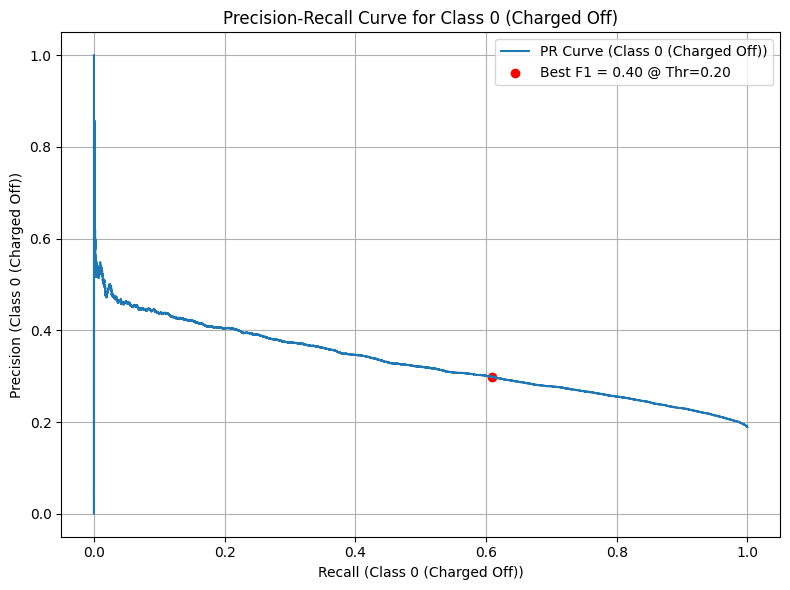

🔎 Best Threshold for Class 0: 0.2017 with F1-score: 0.4013


0.201654693634022

In [11]:
import joblib
stacked_cal = joblib.load(r'D:\Documents\GitHub\credit_line_eligibility\saved_models\stacking_model_calibrated.pkl')

plot_pr_curve(stacked_cal, X_test, y_test, pos_label=0, label_name='Class 0 (Charged Off)')


In [12]:
# Use your trained calibrated stacking model
y_probs = stacked_cal.predict_proba(X_test)[:, 0]  # Probabilities for Class 0 (Charged Off)

# Apply custom threshold
custom_threshold = 0.2017
y_pred_custom = (y_probs >= custom_threshold).astype(int)  # This returns 1 for class 0 if above threshold

# If your positive class is 1 and you're targeting class 0:
# You might want to flip labels to keep 1 as the positive class
y_pred_custom = np.where(y_probs >= custom_threshold, 0, 1)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom, digits=4))



[[ 6388  4098]
 [14973 29951]]
              precision    recall  f1-score   support

           0     0.2990    0.6092    0.4012     10486
           1     0.8796    0.6667    0.7585     44924

    accuracy                         0.6558     55410
   macro avg     0.5893    0.6379    0.5798     55410
weighted avg     0.7698    0.6558    0.6909     55410



Accuracy on Val Data: 0.804502797329002
Classification Report on Val Data: 
               precision    recall  f1-score   support

           0       0.44      0.13      0.20      8389
           1       0.83      0.96      0.89     35939

    accuracy                           0.80     44328
   macro avg       0.63      0.55      0.55     44328
weighted avg       0.75      0.80      0.76     44328

Accuracy on Test Data: 0.8025266197437285
Classification Report on Test Data: 
              precision    recall  f1-score   support

           0       0.43      0.13      0.19     10486
           1       0.82      0.96      0.89     44924

    accuracy                           0.80     55410
   macro avg       0.63      0.54      0.54     55410
weighted avg       0.75      0.80      0.76     55410



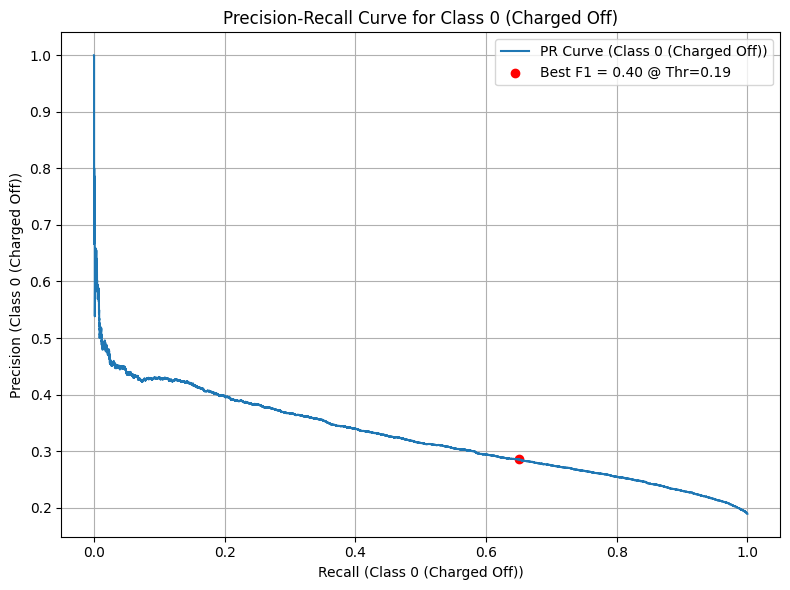

🔎 Best Threshold for Class 0: 0.1877 with F1-score: 0.3969


0.18766182144876475

In [13]:
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib 

# Load the Base models 
rf = joblib.load(r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model.pkl')
xgb = joblib.load(r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model.pkl')
lgbm = joblib.load(r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model.pkl') 

# Meta-learner
meta_learner = LGBMClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ],
    final_estimator=meta_learner,
    cv=cv,
    n_jobs=-1,
    passthrough=True
)

# Fit the model
stacking_cal = stacking_clf.fit(X_train, y_train)
# Save the model
joblib.dump(stacking_cal, r'D:\Documents\GitHub\credit_line_eligibility\saved_models\stacking_model.pkl')

# Predict
y_pred = stacking_clf.predict(X_val)
y_pred_test = stacking_clf.predict(X_test)

# Evaluate
print(f'Accuracy on Val Data: {accuracy_score(y_val, y_pred)}')
print(f'Classification Report on Val Data: \n {classification_report(y_val, y_pred)}')

print(f'Accuracy on Test Data: {accuracy_score(y_test, y_pred_test)}')
print("Classification Report on Test Data: ")
print(classification_report(y_test, y_pred_test))

plot_pr_curve(stacking_cal, X_test, y_test, pos_label=0, label_name='Class 0 (Charged Off)')


In [14]:
# Use your trained calibrated stacking model
y_probs = stacking_cal.predict_proba(X_test)[:, 0]  # Probabilities for Class 0 (Charged Off)

# Apply custom threshold
custom_threshold = 0.1877
y_pred_custom = (y_probs >= custom_threshold).astype(int)  # This returns 1 for class 0 if above threshold

# If your positive class is 1 and you're targeting class 0:
# You might want to flip labels to keep 1 as the positive class
y_pred_custom = np.where(y_probs >= custom_threshold, 0, 1)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom, digits=4))

[[ 6817  3669]
 [17057 27867]]
              precision    recall  f1-score   support

           0     0.2855    0.6501    0.3968     10486
           1     0.8837    0.6203    0.7289     44924

    accuracy                         0.6260     55410
   macro avg     0.5846    0.6352    0.5629     55410
weighted avg     0.7705    0.6260    0.6661     55410



In [8]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

def pr_curve(y_true, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_idx = f1.argmax()
    best_thresh = thresholds[best_idx]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='PR Curve')
    plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold = {best_thresh:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_thresh


#### Custom Stacking Classifier using calibrated base models


Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.40      0.26      0.31     10486
           1       0.84      0.91      0.87     44924

    accuracy                           0.78     55410
   macro avg       0.62      0.58      0.59     55410
weighted avg       0.76      0.78      0.77     55410



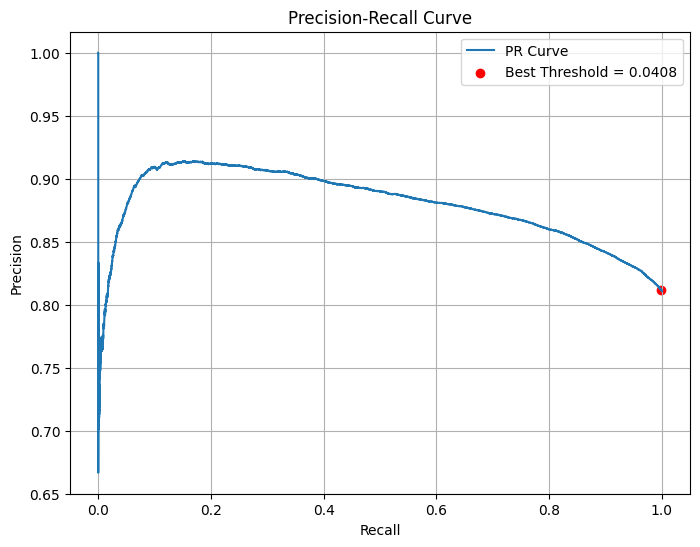

Best Threshold for Custom Stacked Calibrated Model: 0.0408


In [ ]:
from joblib import load
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import warnings
import logging

warnings.filterwarnings('ignore')
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

# Load your pre-saved models
from joblib import load
model_paths = {
    # "rf": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model.pkl',
    # "xgb": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model.pkl',
    # "lgbm": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model.pkl',
    "rf_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model_calibrated.pkl',
    "xgb_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model_calibrated.pkl',
    "lgbm_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model_calibrated.pkl',
}


models = {name: load(path) for name, path in model_paths.items()}

# Define your data
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# OOF predictions for training meta-model
meta_train = np.zeros((X_train.shape[0], len(models)))
meta_test = np.zeros((X_test.shape[0], len(models)))

for idx, (name, model) in enumerate(models.items()):
    test_preds = []
    oof_preds = np.zeros(X_train.shape[0])
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr = y_train[train_idx]
        
        model.fit(X_tr, y_tr)  # retrain on split
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds.append(model.predict_proba(X_test)[:, 1])
    
    meta_train[:, idx] = oof_preds
    meta_test[:, idx] = np.mean(test_preds, axis=0)

# Train the meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_train, y_train)

# Final predictions
final_preds = meta_model.predict(meta_test)

print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_preds))

y_true = y_test 
y_probs = meta_model.predict_proba(meta_test)[:, 1]  # Probabilities for Class 1 (Charged Off)
best_threshold = pr_curve(y_true, y_probs)
print(f"Best Threshold for Custom Stacked Calibrated Model: {best_threshold:.4f}")

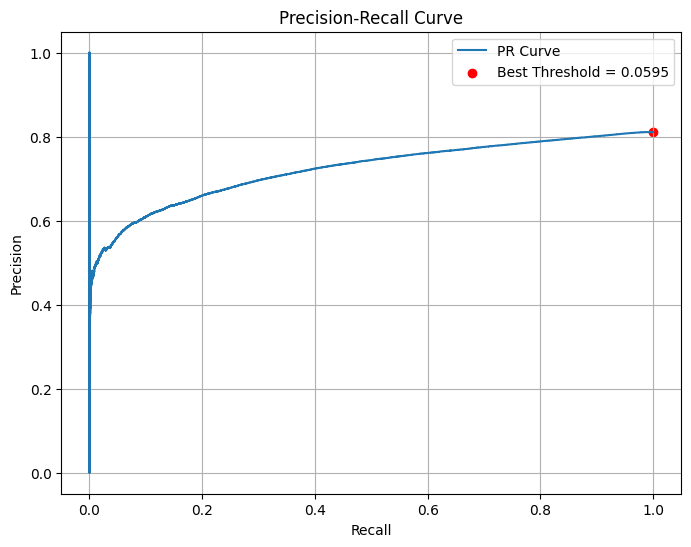

Best Threshold for Custom Stacked Calibrated Model: 0.0595


In [ ]:
y_true = y_test 
y_probs = meta_model.predict_proba(meta_test)[:, 0]  # Probabilities for Class 0 (Charged Off)
best_threshold = pr_curve(y_true, y_probs)
print(f"Best Threshold for Custom Stacked Calibrated Model: {best_threshold:.4f}")

#### Custom stack model with threshold=0.0595


In [13]:
from joblib import load
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
import logging

warnings.filterwarnings('ignore')
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

# Load your pre-saved models
from joblib import load
model_paths = {
    # "rf": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model.pkl',
    # "xgb": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model.pkl',
    # "lgbm": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model.pkl',
    "rf_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\rf_model_calibrated.pkl',
    "xgb_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\xgb_model_calibrated.pkl',
    "lgbm_cal": r'D:\Documents\GitHub\credit_line_eligibility\saved_models\lgbm_model_calibrated.pkl',
}


models = {name: load(path) for name, path in model_paths.items()}

# Define your data
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# OOF predictions for training meta-model
meta_train = np.zeros((X_train.shape[0], len(models)))
meta_test = np.zeros((X_test.shape[0], len(models)))

for idx, (name, model) in enumerate(models.items()):
    test_preds = []
    oof_preds = np.zeros(X_train.shape[0])
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr = y_train[train_idx]
        
        model.fit(X_tr, y_tr)  # retrain on split
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds.append(model.predict_proba(X_test)[:, 1])
    
    meta_train[:, idx] = oof_preds
    meta_test[:, idx] = np.mean(test_preds, axis=0)

# # Calculate class weights
# pos_weight = len(y_train) / (2 * sum(y_train))
# neg_weight = len(y_train) / (2 * (len(y_train) - sum(y_train)))

meta_model = LGBMClassifier(
    scale_pos_weight=0.24,  # Adjusted for class imbalance
    verbose=0
)
meta_model.fit(meta_train, y_train)

# Final predictions
final_preds = meta_model.predict(meta_test)

# Final predictions with custom threshold
# final_probs = meta_model.predict_proba(meta_test)[:, 0]
# threshold = 0.0067 #adjusted threshold
# final_preds = (final_probs >= threshold).astype(int)

print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, final_preds))
print(confusion_matrix(y_test, final_preds))



[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.1960061758802223. Current value: lambda_l2=1.1960061758802223
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.1960061758802223. Current value: lambda_l2=1.1960061758802223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

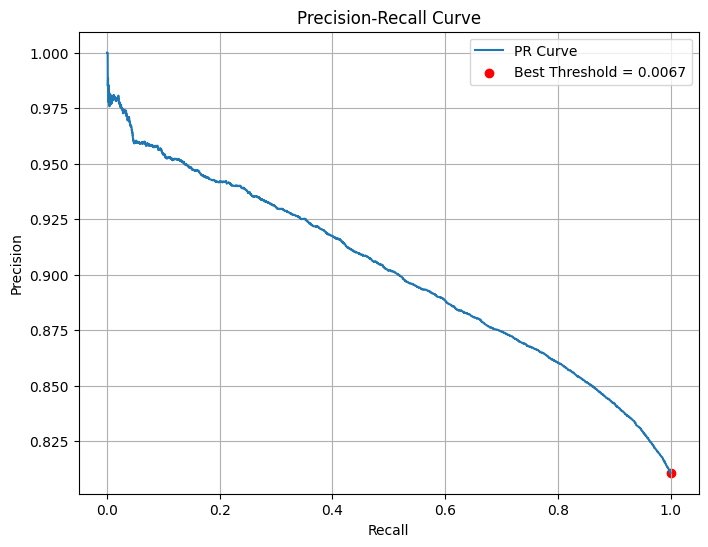

Best Threshold for Custom Stacked Calibrated Model: 0.0067


In [11]:

y_true = y_test 
y_probs = meta_model.predict_proba(meta_test)[:, 1]  # Probabilities for Class 0 (Charged Off)
best_threshold = pr_curve(y_true, y_probs)
print(f"Best Threshold for Custom Stacked Calibrated Model: {best_threshold:.4f}")